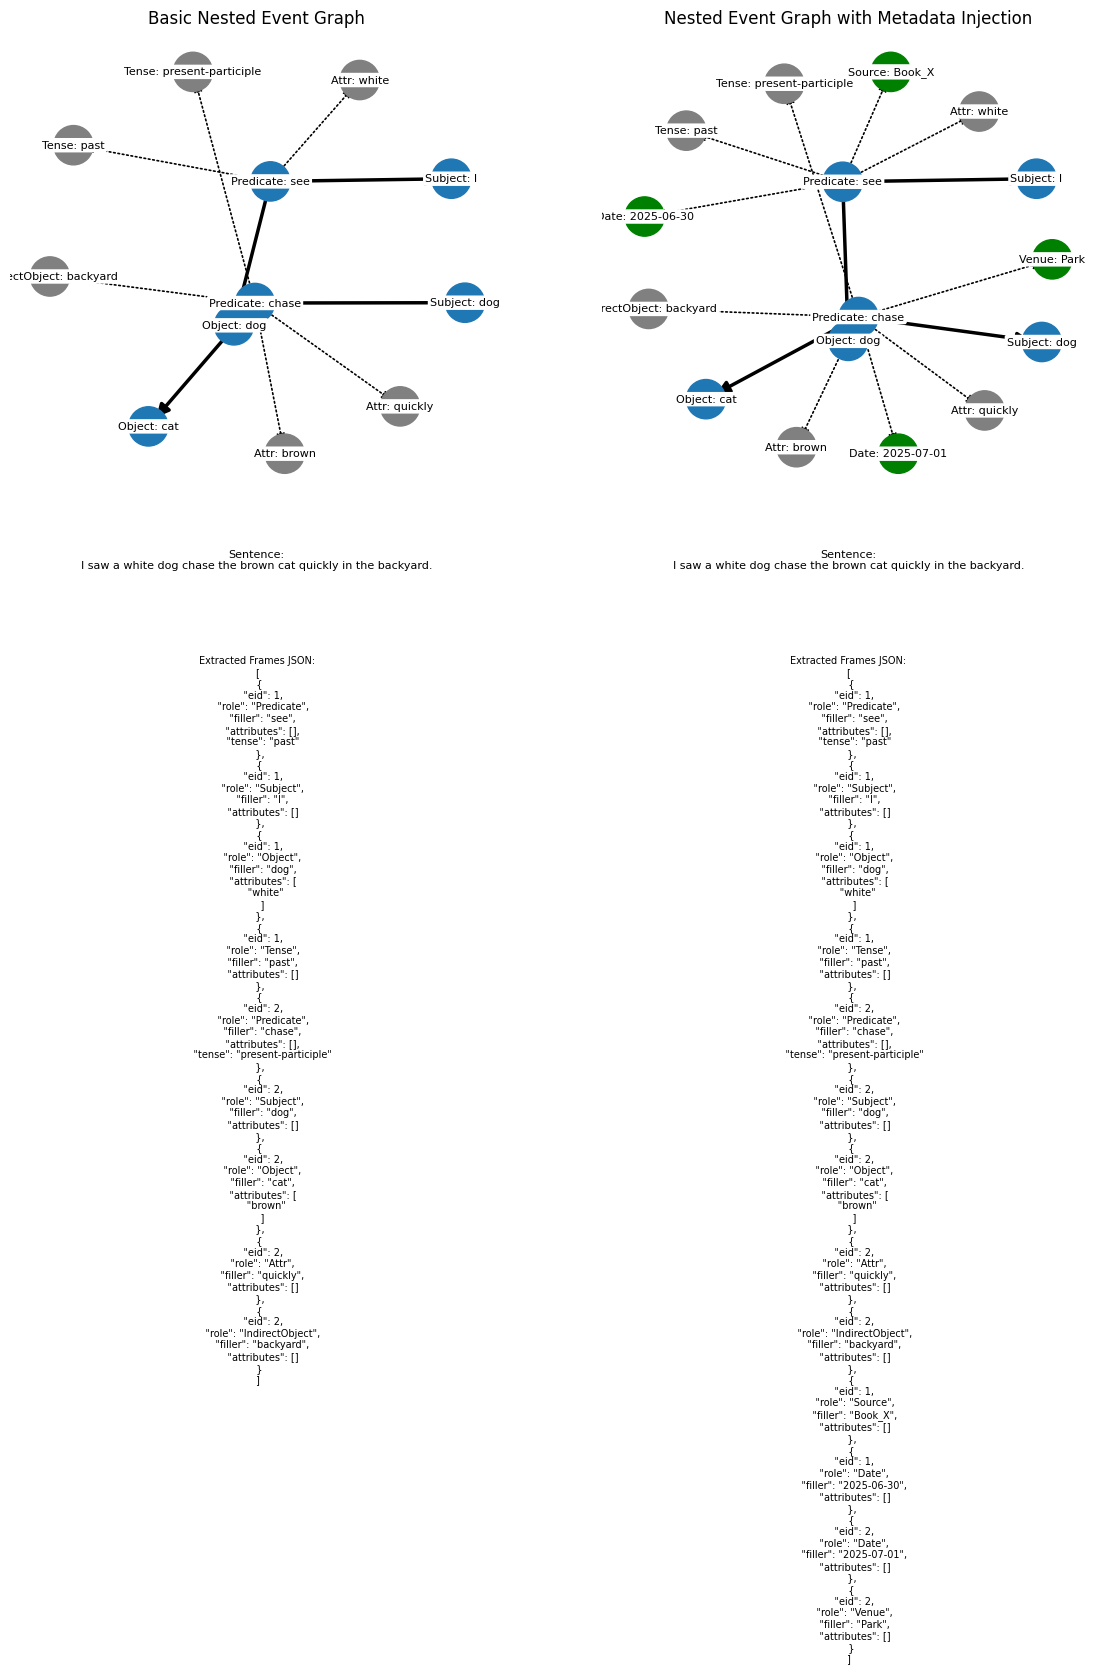

In [15]:
#!/usr/bin/env python3
import networkx as nx
import matplotlib.pyplot as plt
import json

def build_basic_graph():
    G = nx.DiGraph()
    # Event 1
    G.add_node(('e1','Predicate','see'), role='Predicate', filler='see', ntype='spo')
    G.add_node(('e1','Subject','I'),      role='Subject',   filler='I',   ntype='spo')
    G.add_node(('e1','Object','dog'),     role='Object',    filler='dog', ntype='spo')
    G.add_node(('e1','Tense','past'),     role='Tense',     filler='past',ntype='attr')
    G.add_node(('e1','Attr','white'),     role='Attr',      filler='white',ntype='attr')
    # Event 2 (nested under dog)
    G.add_node(('e2','Predicate','chase'),           role='Predicate',   filler='chase', ntype='spo')
    G.add_node(('e2','Subject','dog'),               role='Subject',     filler='dog',    ntype='spo')
    G.add_node(('e2','Object','cat'),                role='Object',      filler='cat',    ntype='spo')
    G.add_node(('e2','Tense','present-participle'), role='Tense',       filler='present-participle',ntype='attr')
    G.add_node(('e2','Attr','brown'),                role='Attr',        filler='brown', ntype='attr')
    G.add_node(('e2','Attr','quickly'),              role='Attr',        filler='quickly',ntype='attr')
    G.add_node(('e2','IndirectObject','backyard'),   role='IndirectObject',filler='backyard',ntype='attr')

    # Edges for event1 (solid)
    G.add_edges_from([
        (('e1','Predicate','see'), ('e1','Subject','I')),
        (('e1','Predicate','see'), ('e1','Object','dog')),
    ])
    # attribute edges for event1
    G.add_edges_from([
        (('e1','Predicate','see'), ('e1','Tense','past')),
        (('e1','Predicate','see'), ('e1','Attr','white')),
    ])

    # Edges for event2
    G.add_edges_from([
        (('e2','Predicate','chase'), ('e2','Subject','dog')),
        (('e2','Predicate','chase'), ('e2','Object','cat')),
    ])
    # attribute edges for event2
    G.add_edges_from([
        (('e2','Predicate','chase'), ('e2','Tense','present-participle')),
        (('e2','Predicate','chase'), ('e2','Attr','brown')),
        (('e2','Predicate','chase'), ('e2','Attr','quickly')),
        (('e2','Predicate','chase'), ('e2','IndirectObject','backyard')),
    ])

    # Nested SPO link: object of e1 → predicate of e2
    G.add_edge(('e1','Object','dog'), ('e2','Predicate','chase'))
    return G

def build_extended_graph():
    G = build_basic_graph()
    # Out‐of‐sentence metadata (green)
    G.add_node(('e1','Source','Book_X'), role='Source', filler='Book_X', ntype='meta_out')
    G.add_node(('e1','Date','2025-06-30'),role='Date',   filler='2025-06-30', ntype='meta_out')
    G.add_edges_from([
        (('e1','Predicate','see'), ('e1','Source','Book_X')),
        (('e1','Predicate','see'), ('e1','Date','2025-06-30')),
    ])
    G.add_node(('e2','Date','2025-07-01'), role='Date',  filler='2025-07-01', ntype='meta_out')
    G.add_node(('e2','Venue','Park'),      role='Venue', filler='Park',       ntype='meta_out')
    G.add_edges_from([
        (('e2','Predicate','chase'), ('e2','Date','2025-07-01')),
        (('e2','Predicate','chase'), ('e2','Venue','Park')),
    ])
    return G

def draw_graph(ax, G, title, sentence, frames):
    # use a looser spring layout to push nodes apart
    pos = nx.spring_layout(G, seed=42, k=1.2, iterations=200, scale=2.0)

    # node colors by type
    color_map = {'spo':'#1f77b4', 'attr':'grey', 'meta_out':'green'}
    node_colors = [ color_map[G.nodes[n]['ntype']] for n in G.nodes ]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=800, ax=ax)

    # labels
    labels = { n: f"{G.nodes[n]['role']}: {G.nodes[n]['filler']}" for n in G.nodes }
    nx.draw_networkx_labels(G, pos, labels, font_size=8, ax=ax,
                            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none"))

    # split edges
    main_edges, attr_edges = [], []
    for u,v in G.edges():
        if G.nodes[v]['ntype']=='spo':
            main_edges.append((u,v))
        else:
            attr_edges.append((u,v))

    # solid thick for SPO links
    nx.draw_networkx_edges(
        G, pos, edgelist=main_edges, ax=ax,
        width=2.5, arrowstyle='-|>', arrowsize=18,
        edge_color='k'
    )
    # dotted thin for attributes & metadata
    nx.draw_networkx_edges(
        G, pos, edgelist=attr_edges, ax=ax,
        width=1.2, style='dotted', arrowstyle='-|>', arrowsize=12,
        edge_color='k'
    )

    ax.set_title(title)
    ax.axis('off')

    # add sentence & JSON below
    ax.text(0.5, -0.12, f"Sentence:\n{sentence}",
            transform=ax.transAxes, ha='center', va='top', fontsize=8)
    ax.text(0.5, -0.35,
            "Extracted Frames JSON:\n" + json.dumps(frames, indent=2),
            transform=ax.transAxes, ha='center', va='top', fontsize=7)

def main():
    sentence = "I saw a white dog chase the brown cat quickly in the backyard."
    basic_frames = [
      {"eid":1,"role":"Predicate","filler":"see","attributes":[],"tense":"past"},
      {"eid":1,"role":"Subject","filler":"I","attributes":[]},
      {"eid":1,"role":"Object","filler":"dog","attributes":["white"]},
      {"eid":1,"role":"Tense","filler":"past","attributes":[]},
      {"eid":2,"role":"Predicate","filler":"chase","attributes":[],"tense":"present-participle"},
      {"eid":2,"role":"Subject","filler":"dog","attributes":[]},
      {"eid":2,"role":"Object","filler":"cat","attributes":["brown"]},
      {"eid":2,"role":"Attr","filler":"quickly","attributes":[]},
      {"eid":2,"role":"IndirectObject","filler":"backyard","attributes":[]},
    ]
    extended_frames = basic_frames + [
      {"eid":1,"role":"Source","filler":"Book_X","attributes":[]},
      {"eid":1,"role":"Date","filler":"2025-06-30","attributes":[]},
      {"eid":2,"role":"Date","filler":"2025-07-01","attributes":[]},
      {"eid":2,"role":"Venue","filler":"Park","attributes":[]},
    ]

    G1 = build_basic_graph()
    G2 = build_extended_graph()

    fig, axes = plt.subplots(1,2,figsize=(14,6))
    draw_graph(axes[0], G1, "Basic Nested Event Graph", sentence, basic_frames)
    draw_graph(axes[1], G2, "Nested Event Graph with Metadata Injection",
               sentence, extended_frames)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


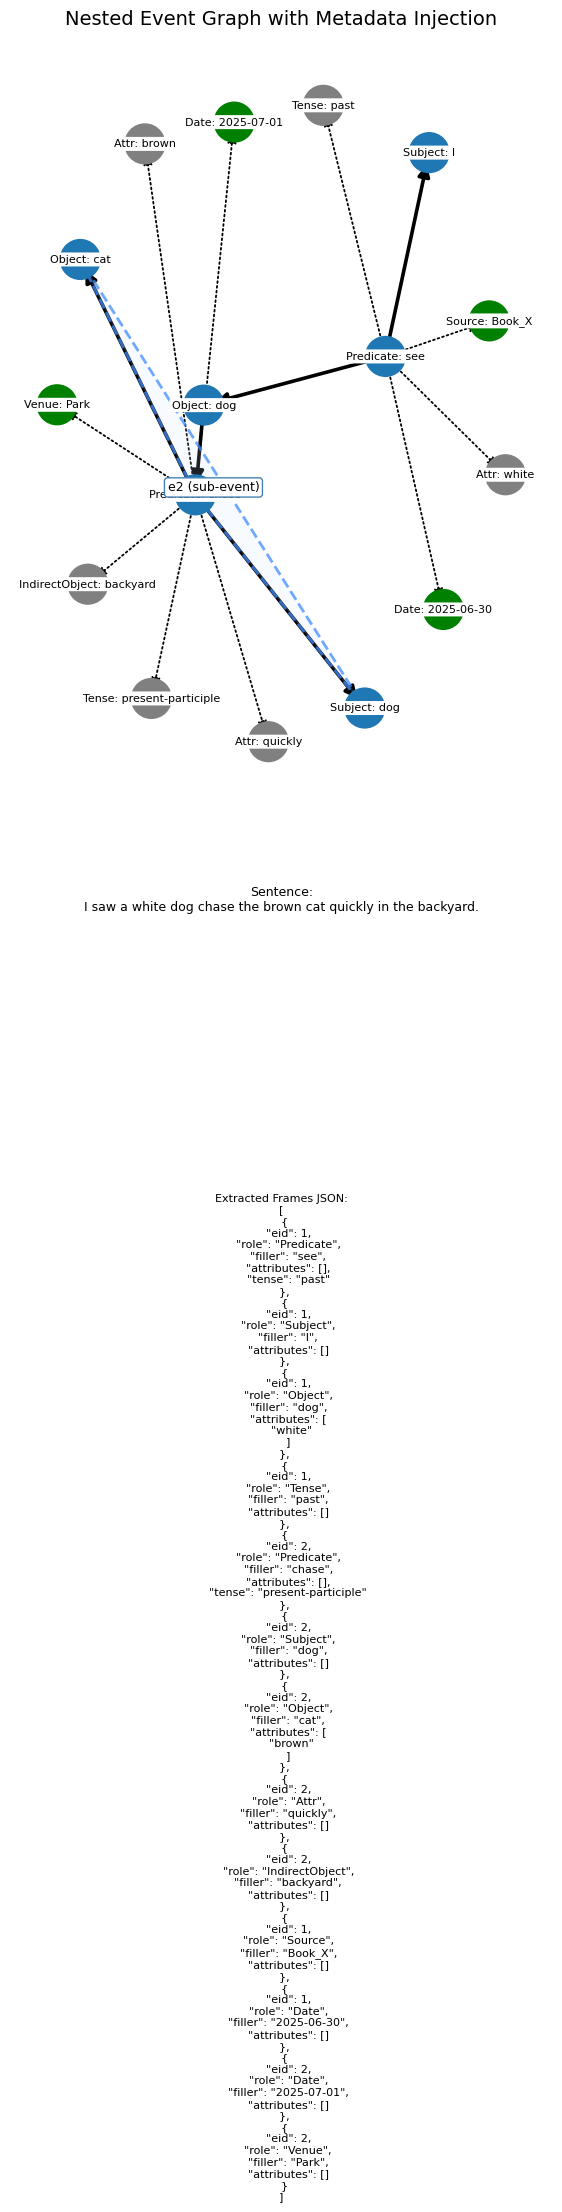

In [13]:
#!/usr/bin/env python3
"""
Nested-event CHV visualiser  ·  v7  (2025-07-01)
Adds post-layout collision-avoidance for the blue SPO nodes.
"""

import json, math, random
from typing import List, Tuple
import numpy as np

# --- NumPy 2.0 compatibility hack (NetworkX<3.2) ---------------------------
if not hasattr(np, "alltrue"):
    np.alltrue = np.all

import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Polygon

# ────────────────────────────────────────────────────────────────────────────
SENTENCE = "I saw a white dog chase the brown cat quickly in the backyard."

BASIC_FRAMES = [
    {"eid":1,"role":"Predicate","filler":"see","attributes":[],"tense":"past"},
    {"eid":1,"role":"Subject","filler":"I","attributes":[]},
    {"eid":1,"role":"Object","filler":"dog","attributes":["white"]},
    {"eid":1,"role":"Tense","filler":"past","attributes":[]},

    {"eid":2,"role":"Predicate","filler":"chase","attributes":[],"tense":"present-participle"},
    {"eid":2,"role":"Subject","filler":"dog","attributes":[]},
    {"eid":2,"role":"Object","filler":"cat","attributes":["brown"]},
    {"eid":2,"role":"Attr","filler":"quickly","attributes":[]},
    {"eid":2,"role":"IndirectObject","filler":"backyard","attributes":[]},
]

EXTENDED_FRAMES = BASIC_FRAMES + [
    {"eid":1,"role":"Source","filler":"Book_X","attributes":[]},
    {"eid":1,"role":"Date","filler":"2025-06-30","attributes":[]},
    {"eid":2,"role":"Date","filler":"2025-07-01","attributes":[]},
    {"eid":2,"role":"Venue","filler":"Park","attributes":[]},
]

# ────────────────────────────────────────────────────────────────────────────
def build_graph() -> nx.DiGraph:
    """Return extended nested-event graph."""
    G = nx.DiGraph()
    # event-1 core
    G.add_node(("e1","Predicate","see"), role="Predicate", filler="see", ntype="spo")
    G.add_node(("e1","Subject","I"),     role="Subject",   filler="I",   ntype="spo")
    G.add_node(("e1","Object","dog"),    role="Object",    filler="dog", ntype="spo")
    # event-1 attrs
    G.add_node(("e1","Tense","past"), role="Tense", filler="past", ntype="attr")
    G.add_node(("e1","Attr","white"), role="Attr", filler="white", ntype="attr")
    # event-2 core
    G.add_node(("e2","Predicate","chase"), role="Predicate", filler="chase", ntype="spo")
    G.add_node(("e2","Subject","dog"),     role="Subject",   filler="dog",   ntype="spo")
    G.add_node(("e2","Object","cat"),      role="Object",    filler="cat",   ntype="spo")
    # event-2 attrs
    G.add_node(("e2","Tense","present-participle"), role="Tense",
               filler="present-participle", ntype="attr")
    G.add_node(("e2","Attr","brown"),   role="Attr", filler="brown",   ntype="attr")
    G.add_node(("e2","Attr","quickly"), role="Attr", filler="quickly", ntype="attr")
    G.add_node(("e2","IndirectObject","backyard"),
               role="IndirectObject", filler="backyard", ntype="attr")
    # metadata
    G.add_node(("e1","Source","Book_X"), role="Source", filler="Book_X", ntype="meta_out")
    G.add_node(("e1","Date","2025-06-30"), role="Date", filler="2025-06-30", ntype="meta_out")
    G.add_node(("e2","Date","2025-07-01"), role="Date", filler="2025-07-01", ntype="meta_out")
    G.add_node(("e2","Venue","Park"),      role="Venue", filler="Park",   ntype="meta_out")

    # edges
    G.add_edges_from([
        (("e1","Predicate","see"), ("e1","Subject","I")),
        (("e1","Predicate","see"), ("e1","Object","dog")),
        (("e2","Predicate","chase"), ("e2","Subject","dog")),
        (("e2","Predicate","chase"), ("e2","Object","cat")),
        # attributes
        (("e1","Predicate","see"), ("e1","Tense","past")),
        (("e1","Predicate","see"), ("e1","Attr","white")),
        (("e2","Predicate","chase"), ("e2","Tense","present-participle")),
        (("e2","Predicate","chase"), ("e2","Attr","brown")),
        (("e2","Predicate","chase"), ("e2","Attr","quickly")),
        (("e2","Predicate","chase"), ("e2","IndirectObject","backyard")),
        # metadata
        (("e1","Predicate","see"), ("e1","Source","Book_X")),
        (("e1","Predicate","see"), ("e1","Date","2025-06-30")),
        (("e2","Predicate","chase"), ("e2","Date","2025-07-01")),
        (("e2","Predicate","chase"), ("e2","Venue","Park")),
        # nesting link
        (("e1","Object","dog"), ("e2","Predicate","chase")),
    ])
    return G

# ────────────────────────────────────────────────────────────────────────────
def convex_hull(pts: List[Tuple[float,float]]):
    pts = sorted({(float(x),float(y)) for x,y in pts})
    if len(pts) < 4: return pts
    def cross(o,a,b): return (a[0]-o[0])*(b[1]-o[1])-(a[1]-o[1])*(b[0]-o[0])
    lo, up = [], []
    for p in pts:
        while len(lo)>1 and cross(lo[-2], lo[-1], p)<=0: lo.pop()
        lo.append(p)
    for p in reversed(pts):
        while len(up)>1 and cross(up[-2], up[-1], p)<=0: up.pop()
        up.append(p)
    return lo[:-1]+up[:-1]

# ────────────────────────────────────────────────────────────────────────────
def _resolve_collisions(pos, nodes, d_min=0.25, max_iter=20):
    """Shift SPO nodes so every pair is at least d_min apart."""
    for _ in range(max_iter):
        moved = False
        for i, n1 in enumerate(nodes):
            for n2 in nodes[i+1:]:
                v = pos[n2] - pos[n1]
                dist = np.linalg.norm(v)
                if dist < d_min and dist > 1e-6:
                    # push each node half the overlap distance
                    shift = 0.5*(d_min - dist) * v / dist
                    pos[n1] -= shift
                    pos[n2] += shift
                    moved = True
        if not moved:
            break
    return pos

# ────────────────────────────────────────────────────────────────────────────
def draw_graph(ax, G, title, frames):
    rnd = random.Random(5)

    # 1) initial Kamada-Kawai then spring
    pos = nx.kamada_kawai_layout(G, weight=None)
    pos = nx.spring_layout(G, pos=pos, seed=6,
                           k=1.4/math.sqrt(len(G)), iterations=200, weight=None)

    # 2) add a bit of jitter
    for n in pos:
        pos[n] += 0.04*np.array([rnd.uniform(-1,1), rnd.uniform(-1,1)])

    # 3) SPO collision-avoidance
    spo_nodes = [n for n in G if G.nodes[n]["ntype"] == "spo"]
    pos = _resolve_collisions(pos, spo_nodes, d_min=0.28)

    # ---- draw -------------------------------------------------------------
    colour = {"spo":"#1f77b4", "attr":"grey", "meta_out":"green"}
    nx.draw_networkx_nodes(
        G, pos, node_size=820,
        node_color=[colour[G.nodes[n]["ntype"]] for n in G.nodes], ax=ax
    )
    labels = {n:f'{G.nodes[n]["role"]}: {G.nodes[n]["filler"]}' for n in G.nodes}
    nx.draw_networkx_labels(
        G, pos, labels, font_size=8,
        bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none"), ax=ax
    )

    main = [(u,v) for u,v in G.edges if G.nodes[v]["ntype"]=="spo"]
    aux  = [(u,v) for u,v in G.edges if G.nodes[v]["ntype"]!="spo"]
    nx.draw_networkx_edges(G, pos, edgelist=main,
                           width=2.6, edge_color="black",
                           arrows=True, arrowstyle="-|>", arrowsize=17, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=aux,
                           width=1.3, style="dotted", edge_color="black",
                           arrows=True, arrowstyle="-|>", arrowsize=13, ax=ax)

    # sub-event hull
    e2_core = [n for n in G if n[0]=="e2" and G.nodes[n]["ntype"]=="spo"]
    if len(e2_core) >= 3:
        hull = convex_hull([pos[n] for n in e2_core])
        ax.add_patch(Polygon(
            hull, closed=True,
            facecolor=(0.80,0.88,1.0,0.15),
            edgecolor=(0.25,0.55,1.0,0.75),
            linewidth=2, linestyle="--"
        ))
        cx, cy = np.mean([p[0] for p in hull]), np.mean([p[1] for p in hull])
        ax.text(cx, cy, "e2 (sub-event)", fontsize=9, ha="center", va="center",
                bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="steelblue"))

    ax.set_title(title, fontsize=14, pad=10)
    ax.axis("off")
    ax.text(0.5, -0.10, "Sentence:\n"+SENTENCE,
            transform=ax.transAxes, ha="center", va="top", fontsize=9)
    ax.text(0.5, -0.50, "Extracted Frames JSON:\n"+json.dumps(frames, indent=2),
            transform=ax.transAxes, ha="center", va="top", fontsize=8)

# ────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    G = build_graph()
    fig, ax = plt.subplots(figsize=(7,10))
    draw_graph(ax, G, "Nested Event Graph with Metadata Injection", EXTENDED_FRAMES)
    plt.tight_layout()
    plt.show()


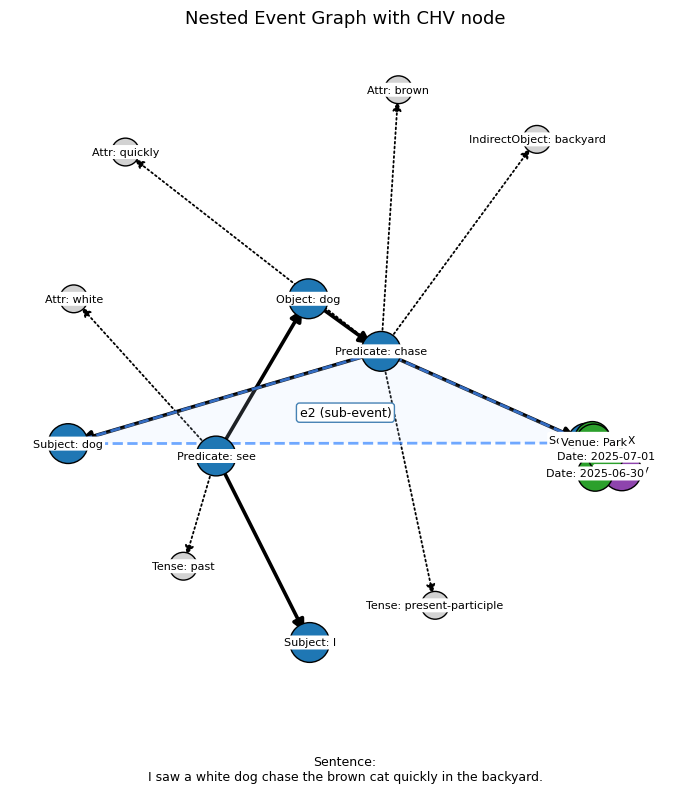

In [24]:
#!/usr/bin/env python3
"""
Nested-event visualiser • v9 (2025-07-01)
 – ONE purple CHV node per sentence
 – grey attr nodes: semi-transparent + labels
"""

import json, math, random
from typing import List, Tuple
import numpy as np

# ───── NumPy 2.0 shim (for NetworkX < 3.2) ─────────────────────────────────
if not hasattr(np, "alltrue"):
    np.alltrue = np.all

import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Polygon

SENTENCE = "I saw a white dog chase the brown cat quickly in the backyard."

# ───────────────────────── graph construction ──────────────────────────────
def build_graph() -> nx.DiGraph:
    G = nx.DiGraph()
    add = lambda eid, role, fill, t: G.add_node((eid, role, fill),
                                                role=role, filler=fill, ntype=t)

    # event-1
    add("e1","Predicate","see","spo")
    add("e1","Subject","I","spo")
    add("e1","Object","dog","spo")
    add("e1","Tense","past","attr");   add("e1","Attr","white","attr")
    # event-2
    add("e2","Predicate","chase","spo")
    add("e2","Subject","dog","spo")
    add("e2","Object","cat","spo")
    add("e2","Tense","present-participle","attr")
    add("e2","Attr","brown","attr");   add("e2","Attr","quickly","attr")
    add("e2","IndirectObject","backyard","attr")

    # single CHV node
    CHV = ("doc","CHV","CHV")
    G.add_node(CHV, role="CHV", filler="CHV", ntype="chv")

    # metadata → CHV
    for m in [("e1","Source","Book_X"), ("e1","Date","2025-06-30"),
              ("e2","Date","2025-07-01"), ("e2","Venue","Park")]:
        add(*m,"meta_out");   G.add_edge(m, CHV, etype="meta")

    # core edges
    G.add_edges_from([
        (("e1","Predicate","see"), ("e1","Subject","I")),
        (("e1","Predicate","see"), ("e1","Object","dog")),
        (("e2","Predicate","chase"), ("e2","Subject","dog")),
        (("e2","Predicate","chase"), ("e2","Object","cat")),
    ])
    # attribute edges
    for tgt in [("e1","Tense","past"), ("e1","Attr","white")]:
        G.add_edge(("e1","Predicate","see"), tgt)
    for tgt in [("e2","Tense","present-participle"),
                ("e2","Attr","brown"), ("e2","Attr","quickly"),
                ("e2","IndirectObject","backyard")]:
        G.add_edge(("e2","Predicate","chase"), tgt)

    # nesting & CHV
    G.add_edge(("e1","Object","dog"), ("e2","Predicate","chase"), etype="nested")
    G.add_edge(("e2","Object","cat"), CHV)          # final link to CHV
    return G

# ───────────────────── helpers ─────────────────────────────────────────────
def convex_hull(pts: List[Tuple[float,float]]):
    pts = sorted({(float(x),float(y)) for x,y in pts})
    if len(pts) < 4: return pts
    cross = lambda o,a,b:(a[0]-o[0])*(b[1]-o[1])-(a[1]-o[1])*(b[0]-o[0])
    lo, up = [], []
    for p in pts:
        while len(lo)>1 and cross(lo[-2],lo[-1],p)<=0: lo.pop()
        lo.append(p)
    for p in reversed(pts):
        while len(up)>1 and cross(up[-2],up[-1],p)<=0: up.pop()
        up.append(p)
    return lo[:-1]+up[:-1]

def resolve_collisions(pos, nodes, d_min=0.28, max_iter=20):
    for _ in range(max_iter):
        moved=False
        for i,n1 in enumerate(nodes):
            for n2 in nodes[i+1:]:
                v=pos[n2]-pos[n1]; dist=np.linalg.norm(v)
                if 0<dist<d_min:
                    shift=0.5*(d_min-dist)*v/dist
                    pos[n1]-=shift; pos[n2]+=shift; moved=True
        if not moved: break
    return pos

# ───────────────────────── drawing ─────────────────────────────────────────
def draw_graph(ax, G):
    rnd = random.Random(4)
    pos = nx.spring_layout(G, seed=6, k=1.4/math.sqrt(len(G)), iterations=200)
    for n in pos: pos[n]+=0.04*np.array([rnd.uniform(-1,1),rnd.uniform(-1,1)])

    pos = resolve_collisions(pos,[n for n in G if G.nodes[n]["ntype"]=="spo"])

    palette = {"spo":"#1f77b4",
               "attr":(0.5,0.5,0.5,0.35),
               "meta_out":"#2ca02c",
               "chv":"#8e44ad"}
    sizes = {"spo":820,"attr":400,"meta_out":650,"chv":800}

    nx.draw_networkx_nodes(G,pos,
        node_color=[palette[G.nodes[n]["ntype"]] for n in G],
        node_size=[sizes[G.nodes[n]["ntype"]] for n in G],
        edgecolors="k",linewidths=1,ax=ax)

    # label everything
    nx.draw_networkx_labels(
        G,pos,
        labels={n:f'{G.nodes[n]["role"]}: {G.nodes[n]["filler"]}' for n in G},
        font_size=8,
        bbox=dict(boxstyle="round,pad=0.18",fc="white",ec="none"),ax=ax)

    main=[(u,v) for u,v in G.edges if G.nodes[v]["ntype"] in {"spo","chv"}]
    aux =[e for e in G.edges if e not in main]
    nx.draw_networkx_edges(G,pos,edgelist=main,width=2.6,
                           edge_color="black",arrows=True,
                           arrowstyle="-|>",arrowsize=17,ax=ax)
    nx.draw_networkx_edges(G,pos,edgelist=aux,width=1.3,style="dotted",
                           edge_color="black",arrows=True,
                           arrowstyle="-|>",arrowsize=13,ax=ax)

    # sub-event hull
    e2_core=[n for n in G if n[0]=="e2" and G.nodes[n]["ntype"]=="spo"]
    if len(e2_core)>=3:
        hull=convex_hull([pos[n] for n in e2_core])
        ax.add_patch(Polygon(hull,closed=True,
            facecolor=(0.80,0.88,1.0,0.15),
            edgecolor=(0.25,0.55,1.0,0.75),linewidth=2,linestyle="--"))
        cx,cy=np.mean([p[0] for p in hull]),np.mean([p[1] for p in hull])
        ax.text(cx,cy,"e2 (sub-event)",fontsize=9,ha="center",va="center",
                bbox=dict(boxstyle="round,pad=0.25",fc="white",ec="steelblue"))

    ax.set_title("Nested Event Graph with CHV node",fontsize=13,pad=8); ax.axis("off")

# ───────────────────────── main ────────────────────────────────────────────
if __name__=="__main__":
    G=build_graph()
    fig,ax=plt.subplots(figsize=(7,8))
    draw_graph(ax,G)
    ax.text(0.5,-0.10,"Sentence:\n"+SENTENCE,
            transform=ax.transAxes,ha="center",va="top",fontsize=9)
    plt.tight_layout(); plt.show()


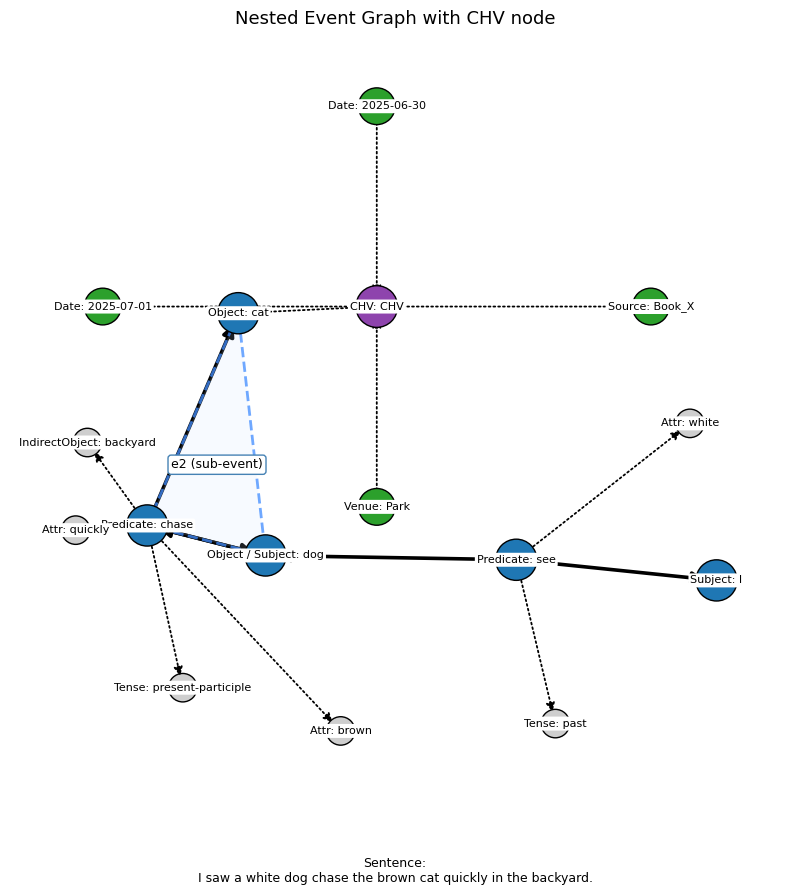

In [32]:
#!/usr/bin/env python3
"""
Nested-event CHV visualiser  ·  v9  (2025-07-01)

• five blue SPO nodes (duplicate “dog” merged into one “Object/Subject: dog”)
• single purple CHV node fed by all green metadata nodes
• grey attributes = smaller & half-transparent
• convex-hull around sub-event e2
• post-layout tweaks remove overlaps
"""

import math, random, json
from typing import List, Tuple, Dict, Set
import numpy as np

#  NumPy 2.0 shim for older NetworkX versions
if not hasattr(np, "alltrue"):
    np.alltrue = np.all

import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Polygon

SENTENCE = "I saw a white dog chase the brown cat quickly in the backyard."

# ────────────────────────────────────────────────────────────────────────────
def convex_hull(pts: List[Tuple[float, float]]) -> List[Tuple[float, float]]:
    """Monotone-chain convex hull."""
    pts = sorted({(float(x), float(y)) for x, y in pts})
    if len(pts) < 4:
        return pts

    def cross(o, a, b):
        return (a[0]-o[0])*(b[1]-o[1]) - (a[1]-o[1])*(b[0]-o[0])

    lo, up = [], []
    for p in pts:
        while len(lo) > 1 and cross(lo[-2], lo[-1], p) <= 0:
            lo.pop()
        lo.append(p)
    for p in reversed(pts):
        while len(up) > 1 and cross(up[-2], up[-1], p) <= 0:
            up.pop()
        up.append(p)
    return lo[:-1] + up[:-1]


def _push_apart(pos: Dict, nodes: List, d_min=0.28, max_iter=25):
    """Resolve overlaps for the given node list."""
    for _ in range(max_iter):
        moved = False
        for i, n1 in enumerate(nodes):
            for n2 in nodes[i + 1:]:
                v = pos[n2] - pos[n1]
                dist = np.linalg.norm(v)
                if 1e-6 < dist < d_min:
                    shift = 0.5 * (d_min - dist) * v / dist
                    pos[n1] -= shift
                    pos[n2] += shift
                    moved = True
        if not moved:
            break
    return pos


# ────────────────────────────────────────────────────────────────────────────
def build_graph() -> nx.DiGraph:
    """
    Build nested-event graph with merged SPO fillers.
    Each blue node carries:
        ntype   - {"spo", "attr", "meta_out", "chv"}
        roles   - set of role names
        filler  - surface token
        eid_set - set of event IDs present in this node
    """
    G = nx.DiGraph()

    def merged_id(fill: str):
        """Single blue node per filler token."""
        return ("spo", fill.lower())

    # helper to insert or update node
    def add(eid: str, role: str, filler: str, ntype: str):
        if ntype == "spo":                # merge duplicates
            n = merged_id(filler)
        else:
            n = (eid, role, filler)
        if n in G:
            G.nodes[n]["roles"].add(role)
            G.nodes[n]["eid_set"].add(eid)
        else:
            G.add_node(
                n,
                roles={role},
                filler=filler,
                ntype=ntype,
                eid_set={eid},
            )
        return n

    # ── SPO core ──────────────────────────────────────────────────────────
    core = [
        ("e1", "Predicate", "see"),
        ("e1", "Subject", "I"),
        ("e1", "Object", "dog"),
        ("e2", "Predicate", "chase"),
        ("e2", "Subject", "dog"),   # duplicate filler "dog"
        ("e2", "Object", "cat"),
    ]
    for e, r, f in core:
        add(e, r, f, "spo")

    # ── attributes ────────────────────────────────────────────────────────
    attrs = [
        ("e1", "Tense", "past"),
        ("e1", "Attr", "white"),
        ("e2", "Tense", "present-participle"),
        ("e2", "Attr", "brown"),
        ("e2", "Attr", "quickly"),
        ("e2", "IndirectObject", "backyard"),
    ]
    for e, r, f in attrs:
        add(e, r, f, "attr")

    # ── metadata ──────────────────────────────────────────────────────────
    meta = [
        ("e1", "Source", "Book_X"),
        ("e1", "Date", "2025-06-30"),
        ("e2", "Date", "2025-07-01"),
        ("e2", "Venue", "Park"),
    ]
    for e, r, f in meta:
        add(e, r, f, "meta_out")

    # ── purple CHV node ───────────────────────────────────────────────────
    CHV = ("CHV",)
    G.add_node(CHV, filler="CHV", roles={"CHV"}, ntype="chv", eid_set=set())

    # fast lookup
    def blue(filler):          # merged blue node by token
        return merged_id(filler)

    def attr(e, r, f):         # attribute node id
        return (e, r, f)

    # main SPO edges
    G.add_edges_from(
        [
            (blue("see"), blue("I")),
            (blue("see"), blue("dog")),
            (blue("chase"), blue("dog")),
            (blue("chase"), blue("cat")),
        ]
    )
    # attributes
    G.add_edges_from(
        [
            (blue("see"), attr("e1", "Tense", "past")),
            (blue("see"), attr("e1", "Attr", "white")),
            (blue("chase"), attr("e2", "Tense", "present-participle")),
            (blue("chase"), attr("e2", "Attr", "brown")),
            (blue("chase"), attr("e2", "Attr", "quickly")),
            (blue("chase"), attr("e2", "IndirectObject", "backyard")),
        ]
    )
    # nesting
    G.add_edge(blue("dog"), blue("chase"))
    # metadata → CHV
    G.add_edges_from([(attr(*m), CHV) for m in meta])
    # final SPO → CHV (binder direction)
    G.add_edge(blue("cat"), CHV)
    return G


# ────────────────────────────────────────────────────────────────────────────
def draw_graph(ax, G: nx.DiGraph, title: str):
    rnd = random.Random(11)

    # initial layout
    pos = nx.spring_layout(G, seed=4, k=1.1 / math.sqrt(len(G)), iterations=250)
    # small jitter
    for n in pos:
        pos[n] += 0.03 * np.array([rnd.uniform(-1, 1), rnd.uniform(-1, 1)])

    # 1) push blue nodes apart
    spo_nodes = [n for n in G if G.nodes[n]["ntype"] == "spo"]
    pos = _push_apart(pos, spo_nodes, d_min=0.32)

    # 2) pin CHV slightly above blue centroid & radial fan metadata
    blue_centroid = np.mean([pos[n] for n in spo_nodes], axis=0)
    CHV = next(n for n in G if G.nodes[n]["ntype"] == "chv")
    pos[CHV] = blue_centroid + np.array([0.0, 0.7])

    meta_nodes = [n for n in G if G.nodes[n]["ntype"] == "meta_out"]
    for i, m in enumerate(meta_nodes):
        angle = i * 2 * math.pi / len(meta_nodes)
        pos[m] = pos[CHV] + 0.7 * np.array([math.cos(angle), math.sin(angle)])

    # 3) light collision pass incl. CHV + meta
    pos = _push_apart(pos, spo_nodes + [CHV] + meta_nodes, d_min=0.28)

    # ── drawing ─────────────────────────────────────────────────────────
    palette = {
        "spo": "#1f77b4",
        "attr": (0.45, 0.45, 0.45, 0.35),
        "meta_out": "#2ca02c",
        "chv": "#8e44ad",
    }
    sizes = {"spo": 880, "attr": 420, "meta_out": 700, "chv": 900}
    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=[sizes[G.nodes[n]["ntype"]] for n in G],
        node_color=[palette[G.nodes[n]["ntype"]] for n in G],
        ax=ax,
        linewidths=1.0,
        edgecolors="black",
    )

    # labels
    labels = {}
    for n in G.nodes:
        roles = sorted(G.nodes[n]["roles"])
        labels[n] = f'{" / ".join(roles)}: {G.nodes[n]["filler"]}'
    nx.draw_networkx_labels(
        G,
        pos,
        labels,
        font_size=8,
        bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none"),
        ax=ax,
    )

    # edge sets
    core_edges = [(u, v) for u, v in G.edges if G.nodes[v]["ntype"] == "spo"]
    aux_edges = [(u, v) for u, v in G.edges if G.nodes[v]["ntype"] != "spo"]

    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=core_edges,
        width=2.6,
        edge_color="black",
        arrows=True,
        arrowstyle="-|>",
        arrowsize=17,
        ax=ax,
    )
    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=aux_edges,
        width=1.3,
        style="dotted",
        edge_color="black",
        arrows=True,
        arrowstyle="-|>",
        arrowsize=13,
        ax=ax,
    )

    #  dashed hull around sub-event e2  (blue chase / dog / cat)
    e2_core = [n for n in spo_nodes if "e2" in G.nodes[n]["eid_set"]]
    if len(e2_core) >= 3:
        hull = convex_hull([pos[n] for n in e2_core])
        ax.add_patch(
            Polygon(
                hull,
                closed=True,
                facecolor=(0.80, 0.88, 1.0, 0.15),
                edgecolor=(0.25, 0.55, 1.0, 0.75),
                linewidth=2,
                linestyle="--",
            )
        )
        cx, cy = np.mean([p[0] for p in hull]), np.mean([p[1] for p in hull])
        ax.text(
            cx,
            cy,
            "e2 (sub-event)",
            fontsize=9,
            ha="center",
            va="center",
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="steelblue"),
        )

    ax.set_title(title, fontsize=13, pad=12)
    ax.axis("off")
    ax.text(
        0.5,
        -0.08,
        f"Sentence:\n{SENTENCE}",
        transform=ax.transAxes,
        ha="center",
        va="top",
        fontsize=9,
    )


# ────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    G = build_graph()
    fig, ax = plt.subplots(figsize=(8, 9))
    draw_graph(ax, G, "Nested Event Graph with CHV node")
    plt.tight_layout()
    plt.show()


## Data specification for this, and suggested tuple

### 📐  “Nested-Event → CHV” **data specification**

*(hand over to the rule-based-extractor teammate)*

---

#### 1 Unit of work

| Level                       | Meaning                                           | Where it comes from        |
| --------------------------- | ------------------------------------------------- | -------------------------- |
| **Document ID** (`doc_id`)  | whole article / post / paragraph chunk            | upstream crawler / store   |
| **Sentence ID** (`sent_id`) | 1-based index inside that document                | sentence splitter          |
| **Event ID** (`eid`)        | one predicate-centered clause inside the sentence | *your* extractor (see 4.1) |

All downstream keys must be **globally unique** when combined:
`"{doc_id}·{sent_id}·{eid}"` (e.g. `"d42·3·e2"`).

---

#### 2 Canonical role inventory

| Group                | Role key                                                                                 | Semantics                  | Typical POS        |
| -------------------- | ---------------------------------------------------------------------------------------- | -------------------------- | ------------------ |
| **Core SPO**         | `Predicate`                                                                              | main verb / verbal nominal | VB, VBN, VBG, NN   |
|                      | `Subject`                                                                                | doer / experiencer         | NP, PRP            |
|                      | `Object`                                                                                 | patient / theme            | NP                 |
| **Extra core**       | `IndirectObject`                                                                         | dative / “to-/for-” object | NP/PP              |
| **Event attributes** | `Tense` (past / present-participle / future…)<br>`Attr` (generic modifier: adv, adj, PP) | grammatical / lexical info | ADV/JJ/PP          |
| **Doc metadata**     | `Date`, `Source`, `Venue`, `Author`, etc.                                                | outside current sentence   | header / file name |

Add more keys if needed but **don’t change spellings** once fixed.

---

#### 3 Graph-shaped output (what the visualiser consumes)

```yaml
# 3.1  Node table  (unordered list)
- node_id: [eid, role, filler]   # tuple OR the special CHV node
  ntype : "spo" | "attr" | "meta_out" | "chv"
  filler: raw surface string (keep hyphens, case unchanged)
  role  : copy of role key
  eid   : same event id (skip / null for "chv")

# 3.2  Edge table  (unordered list)
- head : node_id
  tail : node_id
  etype: "core" | "attr_to_head" | "nesting" | "meta_to_chv"
```

**Rules**

| Edge type          | Create when …                                    | Head → Tail                               |
| ------------------ | ------------------------------------------------ | ----------------------------------------- |
| **core**           | subject/object/IO exists                         | Predicate → Subject/Object/IndirectObject |
| **attr\_to\_head** | attribute belongs to head filler                 | *Head node* → Attribute node              |
| **nesting**        | an argument *is itself* a predicate of sub-event | outer Object/Subject → inner Predicate    |
| **meta\_to\_chv**  | any metadata entry                               | metadata node → CHV node                  |
| **CHV**            | always exactly **one** per sentence              | *final SPO node* → CHV                    |

> *“Final SPO node”* = the **last** token along the linear S→P→O reading of the *outer* event.
> In the sample sentence that is **Object = “cat”**.

---

#### 4 Extractor obligations

##### 4.1 Event segmentation & role filling

1. **Detect predicates** (verbs or verbal nouns).
2. Walk dependency tree to collect **Subject / Object / IndirectObject**.
3. Classify extra **attributes**:

   * **Tense** (finite verb morphology or aux)
   * **Attr** — loose modifiers:

     * adjectives of core NPs (`amod`)
     * adverbs on the verb (`advmod`)
     * PPs headed by “in/at/by…” (`nmod`, `obl`)
4. **Nested event**: if any argument also contains a verb, spawn a new `eid` and mark the **nesting edge**.

##### 4.2 Metadata harvesting

*Outside the sentence*, pick up quasi-structured signals once per **document**:
`title`, `byline`, date regex, file name, URL domain, section header.

Produce nodes of `ntype="meta_out"`.
All of them link **only** to the CHV.

##### 4.3 Node merging rule

If two **SPO** nodes in the *same sentence* share the **same lower-cased filler**, merge them into one blue node (roles set becomes union).
Example: “dog” acts as *Object* of `see` **and** *Subject* of `chase`.

---

#### 5 Recommended JSON stub

```jsonc
{
  "doc_id": "d42",
  "sent_id": 1,
  "events": [
    {
      "eid": "e1",
      "Predicate": "see",
      "Subject":  "I",
      "Object" :  "dog",
      "Tense"  :  "past",
      "Attr"   :  [],
      "metadata": { "Source": "Book_X", "Date": "2025-06-30" }
    },
    {
      "eid": "e2",
      "Predicate": "chase",
      "Subject":  "dog",
      "Object":   "cat",
      "Tense":    "present-participle",
      "Attr":     ["quickly"],
      "IndirectObject": "backyard",
      "metadata": { "Date": "2025-07-01", "Venue": "Park" }
    }
  ],
  "nesting": [
    { "outer_eid": "e1", "outer_role": "Object", "inner_eid": "e2" }
  ]
}
```

*Your extractor may emit this JSON; a thin adapter can convert it to the node/edge tables above.*

---

#### 6 Validation checklist (CI can enforce)

| Check                                                                     | Rationale                     |
| ------------------------------------------------------------------------- | ----------------------------- |
| Exactly **1 CHV** node per sentence                                       | visualiser expects one centre |
| All `core` edges originate at a `Predicate`                               | keeps blue fan-out            |
| No attribute of type `Attr` attaches to a Predicate unless it’s an adverb | stops “white”→verb mistakes   |
| All metadata nodes have exactly **1 outgoing** edge (to CHV)              | tidy green fan-out            |
| Graph is **acyclic** except the allowed nesting shortcut                  | layout stays stable           |

---

Hand this spec to the rule-based teammate; once their extractor outputs JSON that satisfies the table above, the v10 visualiser will render the same clean figure with **real data**.
